## Dataset description
Los ficheros contienen un total 55 variables: las 3 primeras de ellas relativas a la identificación de los registros y las 8 últimas variables son distintas referencias geométricas y relativas al entorno (geometría del edificio, métricas geométricas generadas automáticamente -GEOM-, metros cuadrados, año construcción y nº de plantas de los edificios del entorno).


Las imágenes satelitales se han tratado y se ha extraído información de 4 canales (R, G, B y NIR), correspondientes a las bandas de color rojo, verde y azul, y el infrarrojo cercano. El valor mostrado corresponde a la intensidad por deciles en cada imagen. Estas variables empiezan con la letra “Q”.


### Sobre el reto
Los datos representan las características de un grupo de referencias catastrales de la zona de Madrid.  
El objetivo es predecir el uso de cada registro propuesto. Es un problema de clasificación multietiqueta: hay 6 categorías no balanceadas. 
Se presentan 2 conjuntos de datos: “Modelar…” contiene 103.230 registros con 56 variables incluyendo la variable objetivo y “Estimar…” contiene 5.618 registros con 55 variables. 
Se permite el enriquecimiento de datos, siempre y cuando se cumplan que los datos sean públicos, accesibles y legales.

### Las variables 
- La referencia catastral está ofuscada por lo que no es consultable, solo es válida como identificador de registro.  
- La información de longitud-latitud ha sido escalada y desplazada aleatoriamente (manteniendo la relación de posición con el resto de puntos). 
- El principal grupo de variables es información sobre los canales de color R-G-B e infrarrojo de las imágenes tomadas por satélite. Hay 11 variables extraídas de cada uno de estos canales, que representan el valor o densidad en cada decil.  
  - Así, la variable **Q_R_4_0_0** representa el valor para el canal Red en el decil 0, 
  - la variable **Q_G_3_0_8** representa el valor para el canal Green del decil 8 etc. 
  - La identificación “**Q_NIR…**” representa el canal en infrarrojo. 
- A continuación, hay 1 variable de área y 4 variables que condensan información de tipo geométrico sobre la parcela/registro.  
  - El **MAXBUILDINGFLOOR** se refiere a la altura máxima de los registros colindantes, no al propio registro. El año de construcción también se refiere al entorno. 
  - Por último, se presenta una variable categórica representativa de la calidad según los datos de catastro (menor valor, menor calidad). 


### La entrega intermedia 
Se habilita un día **(10 de marzo)** para presentar una “entrega intermedia”, en el que los equipos podrán enviar 2 “ficheros_respuestas” distintos (es decir, la predicción para los registros de “Estimar…”). No hay que enviar script ni presentación.  La Organización, al día siguiente, comunicará la métrica y la posición relativa del equipo en el total de la competición. Este mecanismo es optativo y no será considerado como una entrega oficial evaluable por el jurado local, tan solo será un medio para retroalimentar y mejorar vuestro trabajo. 

## Evaluación: 
#### SE VALORARÁ
- **La calidad y la técnica utilizada para generar un modelo.**
Se analizará la técnica analítica utilizada y se compararán objetivamente los valores reales frente a los valores predichos por el modelo. La métrica para maximizar es la “precisión”.
- **Comunicación.**
Que la documentación interna aportada (códigos, comentarios) esté correctamente expresada y estructurada, y sea reproducible. En la Fase de Presentación de mejores trabajos, el Jurado tendrá en cuenta que el modelado y los resultados obtenidos se transmitan de forma clara y concisa.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import *

C:\Users\HPfamiliaRuiz-Tagle\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
estimate = pd.read_csv("Estimar_UH2020.txt", sep = "|")
data = pd.read_csv("Modelar_UH2020.txt", sep = "|")
estimate["CLASE"] = "UNKNOWN"
total = pd.concat([data,estimate])

In [3]:
balanced_data = pd.read_csv("balanced_data.csv", index_col = 0)
balanced_data_std = pd.read_csv("balanced_data_standarized.csv", index_col = 0)
#data_std = pd.read_csv("data_standarized.csv", index_col = 0)

In [9]:
# Distribucion de las clases en los datos
d = total[["X","CLASE"]].groupby("CLASE").count()
class_percentage = d/d["X"].sum()*100

In [87]:
estimate_processed = process_data(estimate)

In [88]:
estimate_processed.head()

,ID,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,...,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE,UNKNOWN
0,44198C2A811A4DF4,-0.278537,-0.500159,-0.202516,0.490388,0.596565,0.610419,0.512759,0.419787,0.313485,...,-0.225719,-2.532834,-0.758520,-0.795816,-0.471649,0.963777,0.159398,0.721499,UNKNOWN,1.0
1,216F638609E0E39E,-0.057833,0.200893,-0.207281,-0.076548,0.166334,0.303246,0.332604,0.304057,0.225172,...,-0.201232,-0.845484,-0.272811,-0.537166,-0.688822,-0.248355,1.001302,1.333307,UNKNOWN,1.0
2,FFFCEFB11E257364,-0.298531,0.813424,-0.207281,-0.457653,0.062790,0.367480,0.506288,0.570240,0.531768,...,-0.266229,-1.211383,-0.390993,-0.014255,0.723581,-0.248355,0.159398,-1.113924,UNKNOWN,1.0
3,596C5C8CE10BCF,-0.335487,3.392205,-0.207281,-2.037642,-2.718098,-3.090295,-3.256640,-3.156575,-2.793802,...,2.683329,-1.046537,-0.900433,-0.900507,-0.440439,0.917156,0.440033,-0.502116,UNKNOWN,1.0
4,F931B9FA2A8641D1,-0.000147,-1.593227,-0.177416,1.810192,1.433183,1.096232,0.847218,0.697583,0.682416,...,0.009127,0.187010,-0.357406,-0.711087,-0.964130,-0.434836,-0.121237,-1.113924,UNKNOWN,1.0


In [10]:
d

,X
CLASE,
AGRICULTURE,338
INDUSTRIAL,4490
OFFICE,1828
OTHER,1332
PUBLIC,2976
RESIDENTIAL,90173
RETAIL,2093
UNKNOWN,5618


<BarContainer object of 8 artists>

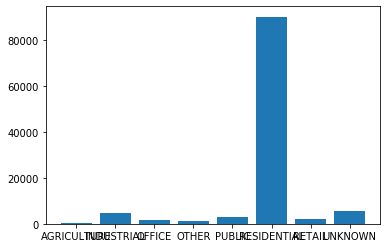

In [10]:
plt.bar(d.index, d.X)

# Correlation matrix

In [13]:
data.head()

,ID,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,...,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE
0,35984B9C3E7CD9A1,2207357872,165920300,0.000000,443.001300,616.001697,746.998401,872.996472,1009.000946,1159.002319,...,10951.926645,144.426900,0.557237,0.067249,0.057372,0.853127,2002,0.0,2,RESIDENTIAL
1,F9D04BF6D037F8FB,2189757160,165463267,0.000059,443.899011,627.999060,770.001611,904.999988,1032.998474,1165.001636,...,7048.367637,38.342550,0.709884,0.125156,0.147929,1.181953,1949,1.0,8,RESIDENTIAL
2,B89D5711AFF8C423,2240147335,165690752,0.000000,353.502274,523.003601,644.001831,760.997131,876.999634,1006.997498,...,7013.073271,108.794384,0.517702,0.058268,0.081666,1.401552,1986,1.0,5,RESIDENTIAL
3,1C3478AC1522E7E4,2227146459,165934099,0.000000,268.000613,376.999609,478.003784,575.001233,683.997742,809.005994,...,6216.880538,155.224455,0.450871,0.053591,0.054201,1.011382,1999,1.0,2,RESIDENTIAL
4,4D12AA5009064345,2212350459,165681791,0.000000,318.997910,492.003845,632.999634,757.002197,882.999908,1019.008911,...,7092.767616,1789.873366,0.458819,0.012858,0.019936,1.550478,1966,8.0,6,RESIDENTIAL


In [29]:
data_processed = process_data(data)

In [24]:
data_processed.head()

,ID,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,...,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE,AGRICULTURE,INDUSTRIAL,OFFICE,OTHER,PUBLIC,RESIDENTIAL,RETAIL
0,35984B9C3E7CD9A1,-0.054523,1.592028,-0.014450,0.606888,0.554535,0.457173,0.403570,0.407104,0.423097,...,-1.279064,1.994747,RESIDENTIAL,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,F9D04BF6D037F8FB,-0.694149,-0.648112,0.004105,0.615913,0.653327,0.624149,0.612081,0.548643,0.455278,...,-0.939493,-1.810371,RESIDENTIAL,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,B89D5711AFF8C423,1.137074,0.466902,-0.014450,-0.292863,-0.211261,-0.290460,-0.326132,-0.371452,-0.392282,...,-0.939493,0.092188,RESIDENTIAL,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1C3478AC1522E7E4,0.664611,1.659663,-0.014450,-1.152428,-1.413535,-1.495408,-1.537939,-1.509795,-1.454340,...,-0.939493,1.994747,RESIDENTIAL,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4D12AA5009064345,0.126911,0.422980,-0.014450,-0.639742,-0.466529,-0.370322,-0.352160,-0.336062,-0.327851,...,1.437501,-0.541999,RESIDENTIAL,0.0,0.0,0.0,0.0,0.0,1.0,0.0


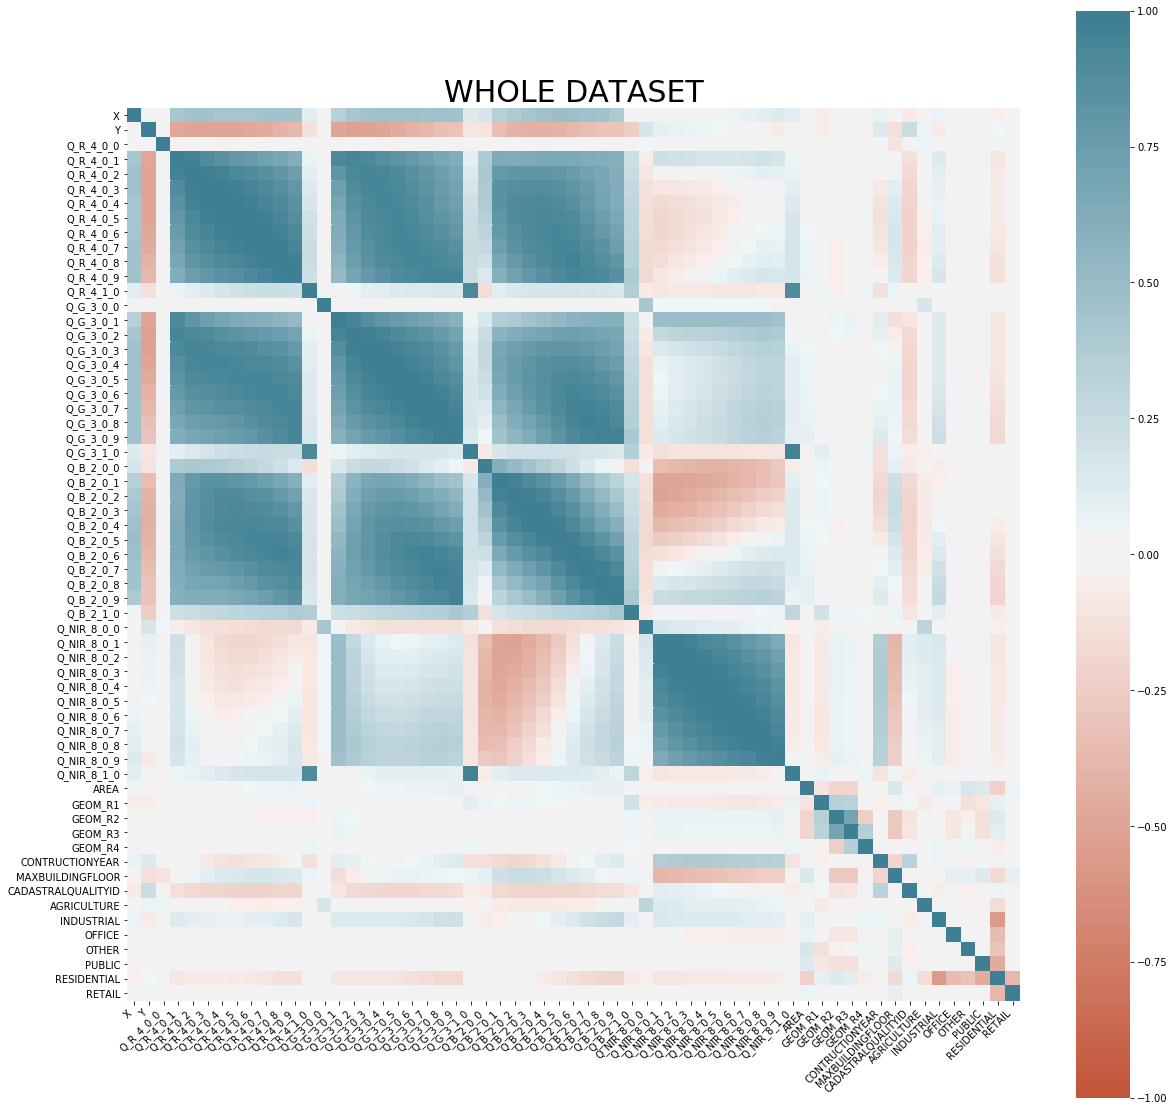

In [15]:
plot_corr(data_processed,"WHOLE DATASET")

# Corr matrix with balanced classes

In [23]:
residential_data = data[data.CLASE=="RESIDENTIAL"]
residential_sample = residential_data.sample(5000)
residential_not_in_sample = residential_data.drop(residential_sample.index)
no_residential_data = data[data.CLASE!="RESIDENTIAL"]
balanced_data = pd.concat([no_residential_data,residential_sample])


In [24]:
print(residential_data.shape)
print(residential_sample.shape)
print(residential_not_in_sample.shape)

(90173, 56)
(5000, 56)
(85173, 56)


<BarContainer object of 7 artists>

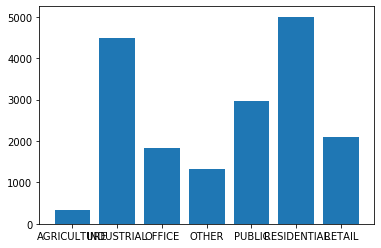

In [61]:
import random

# Datos de la clase "residential"
residential_data = data[data.CLASE=="RESIDENTIAL"]

# Escogemos 5000 índices de las instancias de manera aleatoria
residential_sample_indexes = random.sample(list(residential_data.index), 5000) 
residential_sample = residential_data.loc[residential_sample_indexes]

# Almacenamos los datos no escogidos por la muestra aleatoria
residential_not_in_sample = residential_data.drop(residential_sample_indexes)

# De los datos originales, eliminamos todos los residential
no_residential_data = data[data.CLASE!="RESIDENTIAL"]

# Unimos los datos no residential con la muestra aleatoria
balanced_data = no_residential_data.append(residential_sample)

# Distribucion de las clases en los datos
d = balanced_data[["X","CLASE"]].groupby("CLASE").count()
class_percentage = d/d["X"].sum()*100
plt.bar(d.index, d.X)


<BarContainer object of 7 artists>

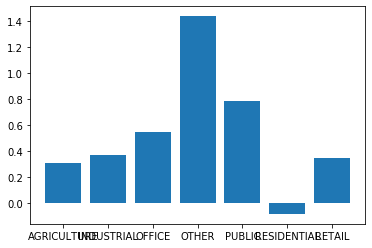

In [27]:
d = balanced_data[["AREA", "CLASE"]].groupby("CLASE").mean()
#class_percentage = d/d["X"].sum()*100
plt.bar(d.index, d.AREA)

In [58]:
balanced_data_std = process_data(balanced_data)

(18057, 56)
(18057, 56)
(18057, 56)
(18057, 56)
(18057, 56)
(18057, 7)
(18057, 63)


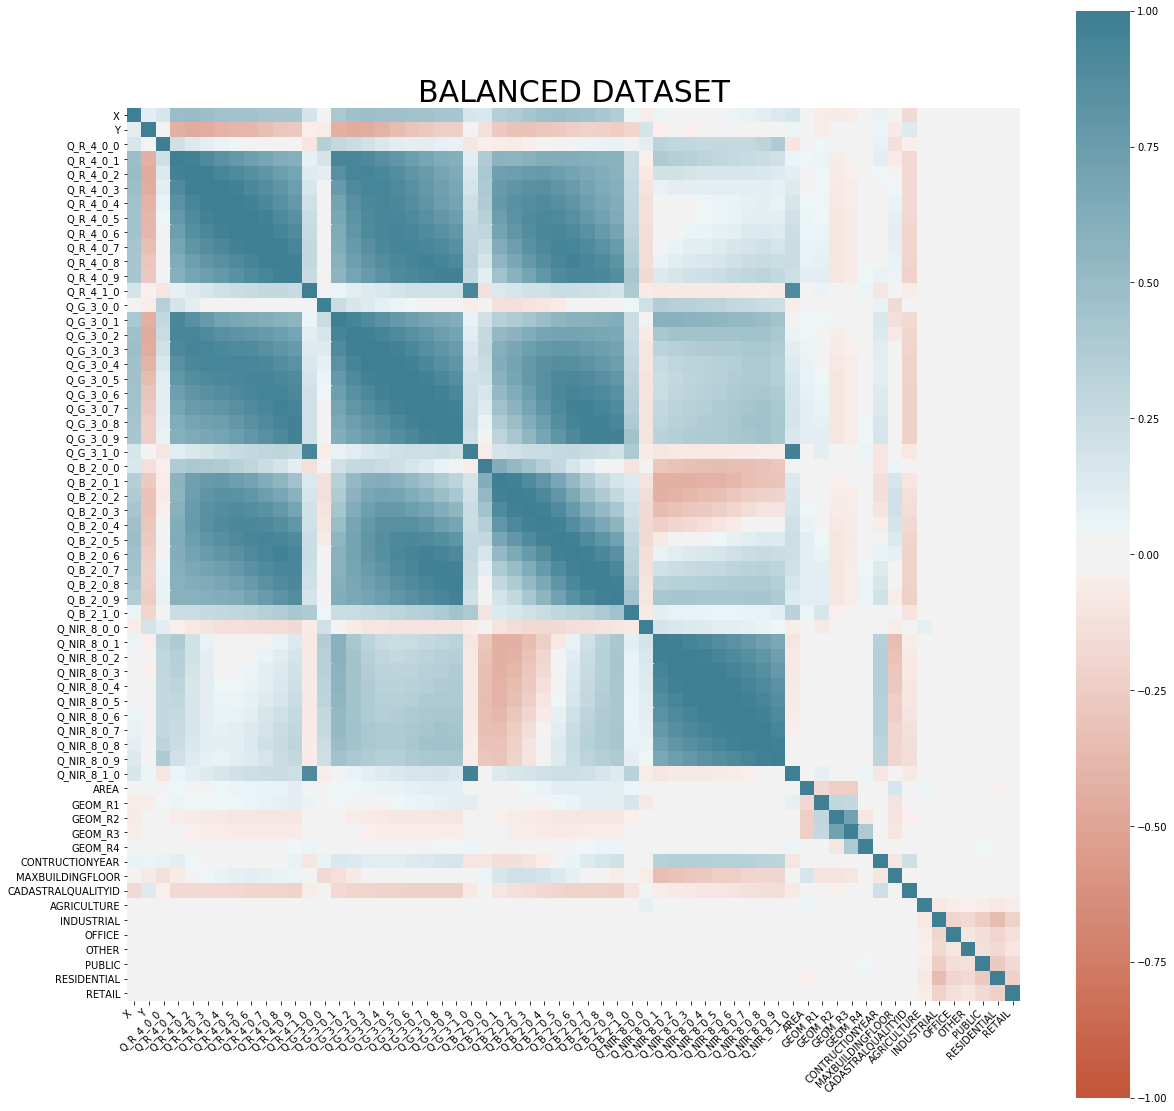

In [18]:
plot_corr(balanced_data_std, "BALANCED DATASET")

## Export data to csv

In [65]:
print(data_processed.shape)
print(balanced_data.shape)
print(balanced_data_std.shape)

(103230, 63)
(18057, 56)
(18057, 63)


In [64]:
data_processed.to_csv("data_standarized.csv")
balanced_data.to_csv("balanced_data.csv")
balanced_data_std.to_csv("balanced_data_standarized.csv")

# Plot RGB channels

In [7]:
rgbnir_cols = data.columns.str.contains("Q_")
rgbnir = data.iloc[:,rgbnir_cols]
#We normalize the data in all channels
rgbnir_std = (rgbnir - rgbnir.mean())/rgbnir.std()

In [6]:
df_r, df_g, df_b, df_nir = extract_channels(data)

In [7]:
df_r, df_g, df_b, df_nir = extract_channels(rgbnir_std)

In [8]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

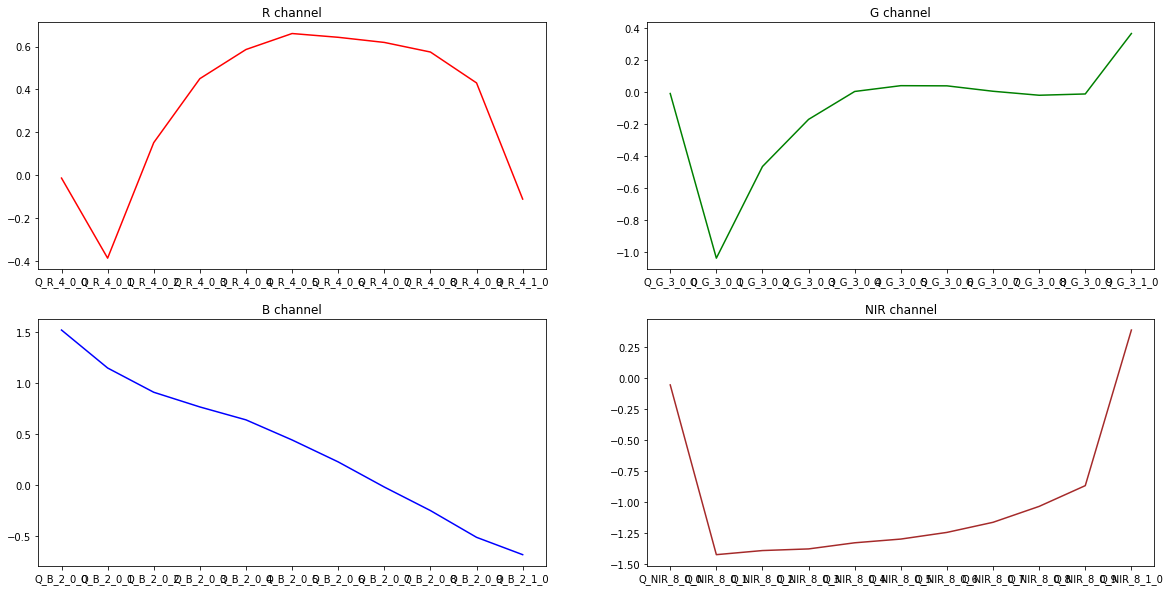

In [84]:

def f(x):
    fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(2,2,figsize=(20,10))
    ax1.set_title("R channel")
    ax2.set_title("G channel")
    ax3.set_title("B channel")
    ax4.set_title("NIR channel")
    ax1.plot(df_r.iloc[x], color = "red")
    ax2.plot(df_g.iloc[x], color = "green")
    ax3.plot(df_b.iloc[x], color = "blue")
    ax4.plot(df_nir.iloc[x], color = "brown")
    
interact(f, x=20);

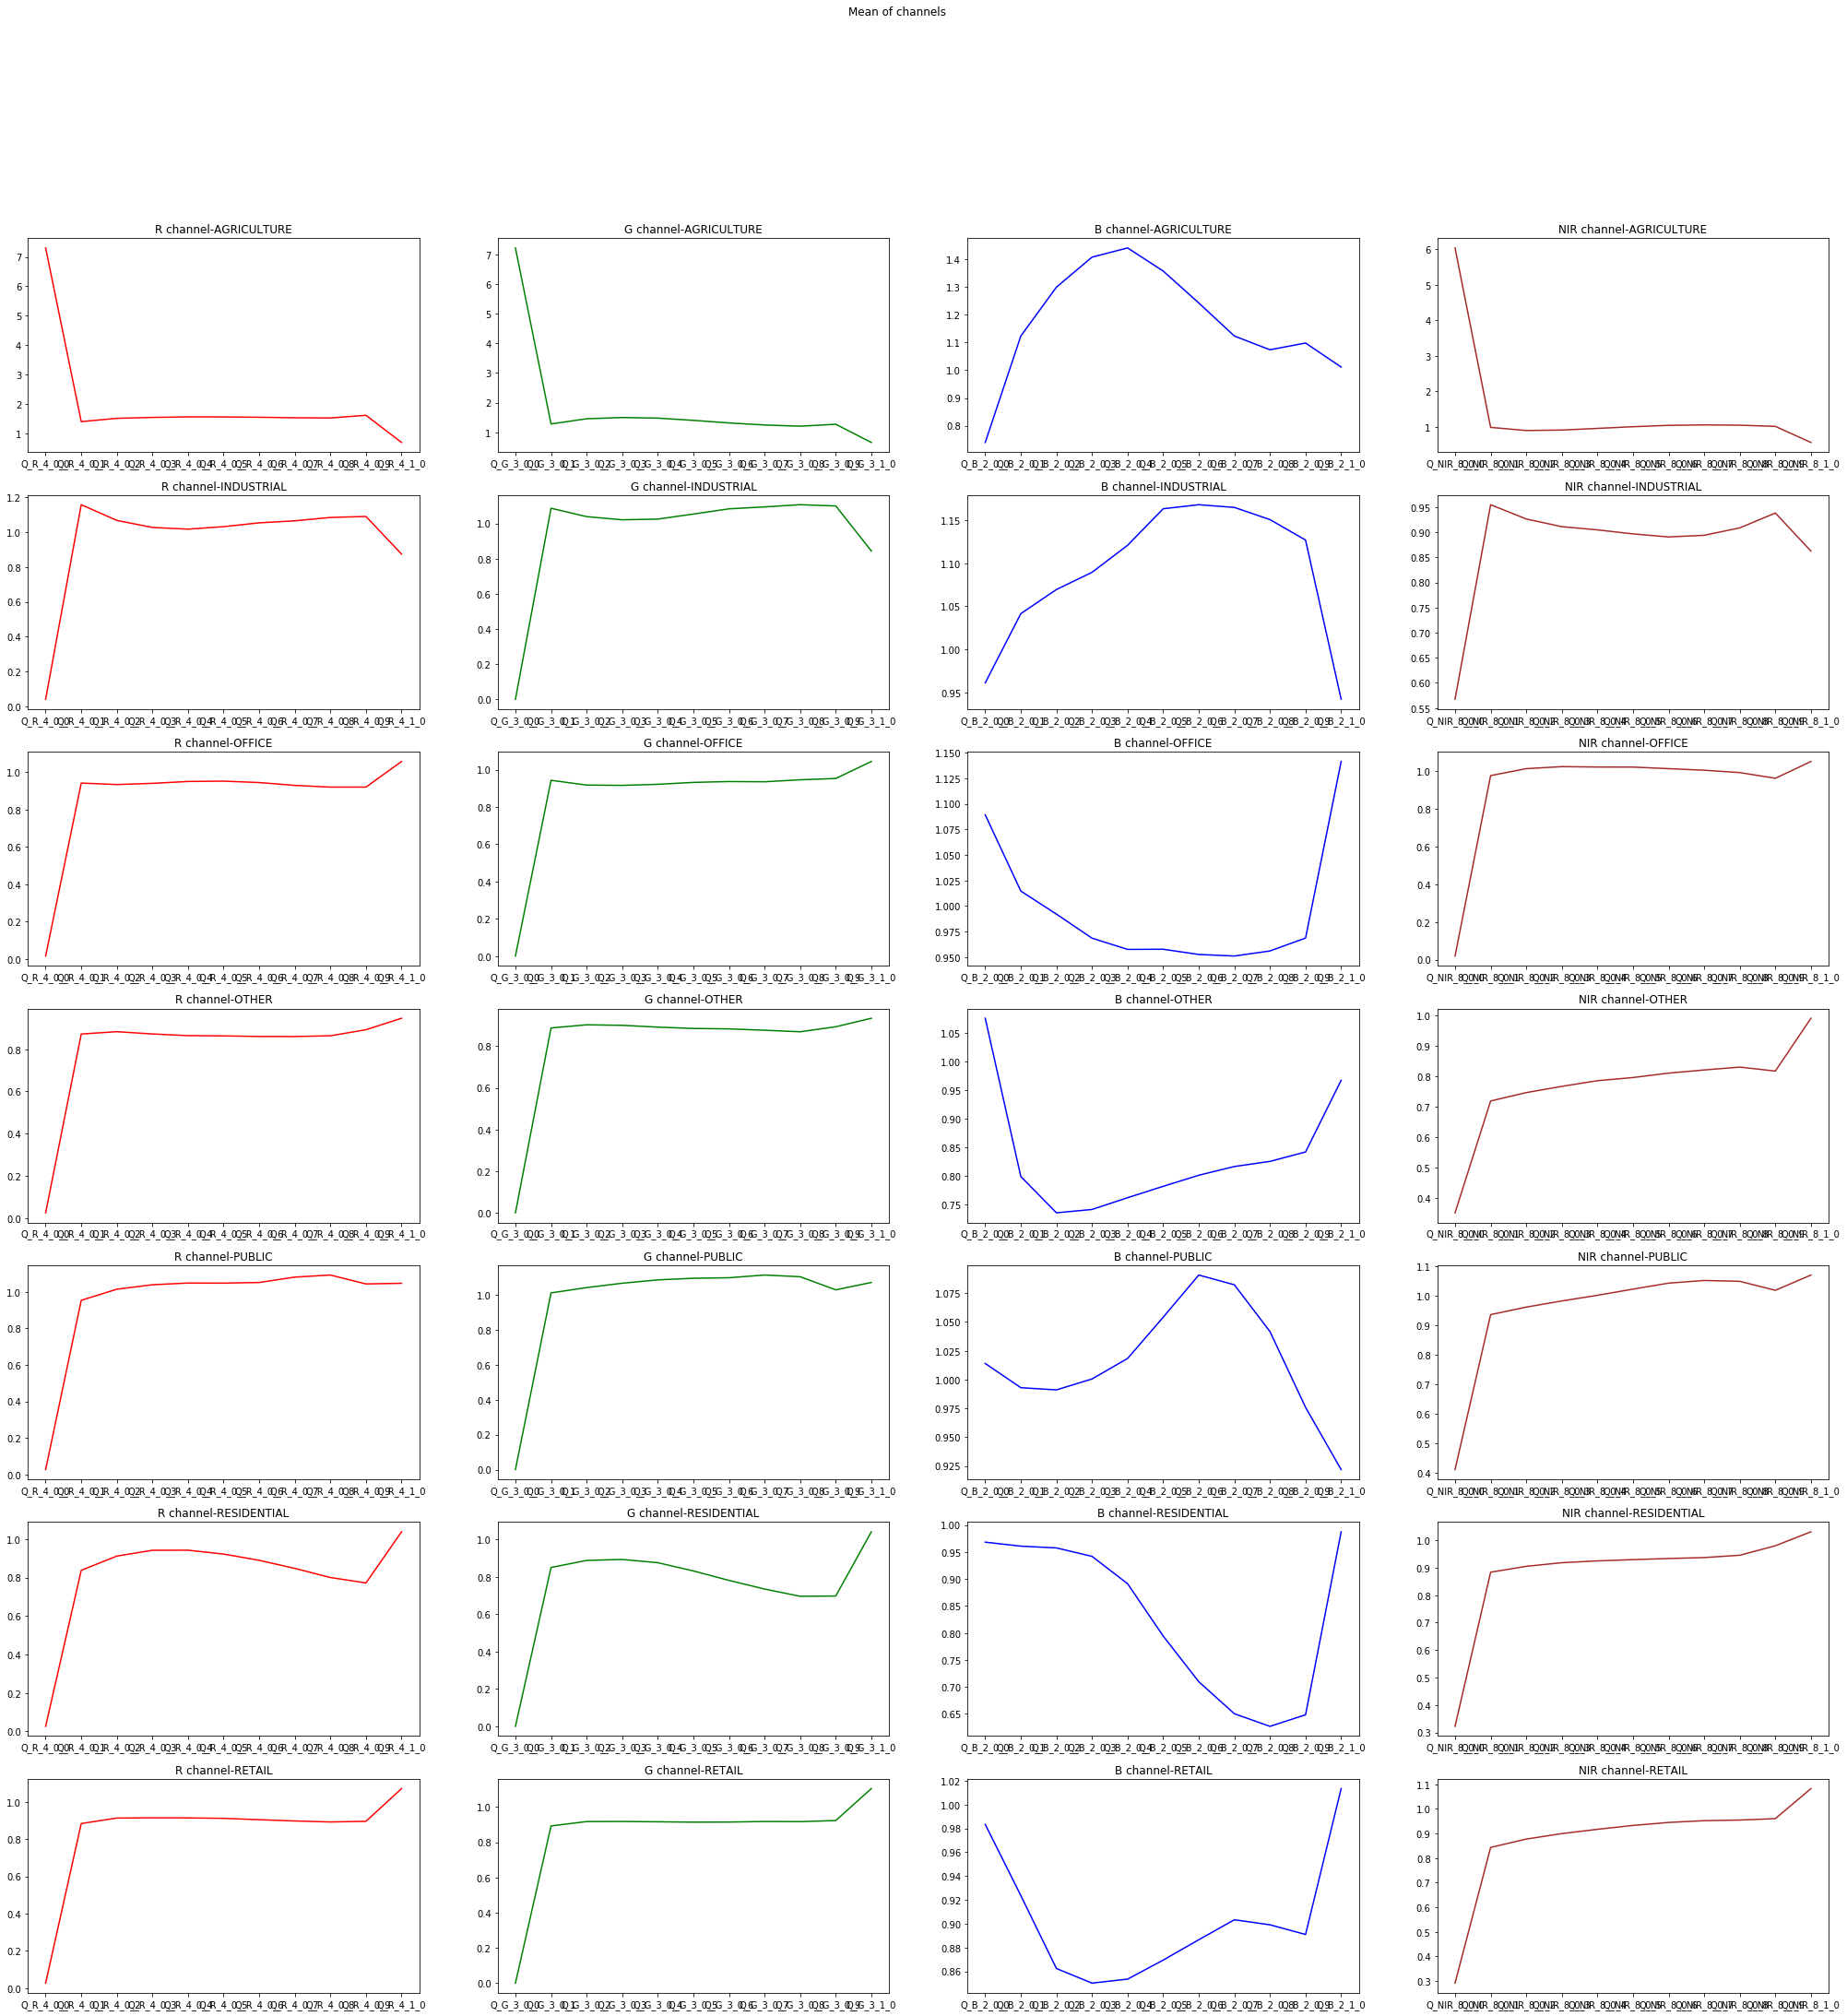

In [19]:
class_std = group.groupby("CLASE").std()
plot_all_channels(class_std)

/Users/juanluisrto/anaconda3/envs/tfm/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


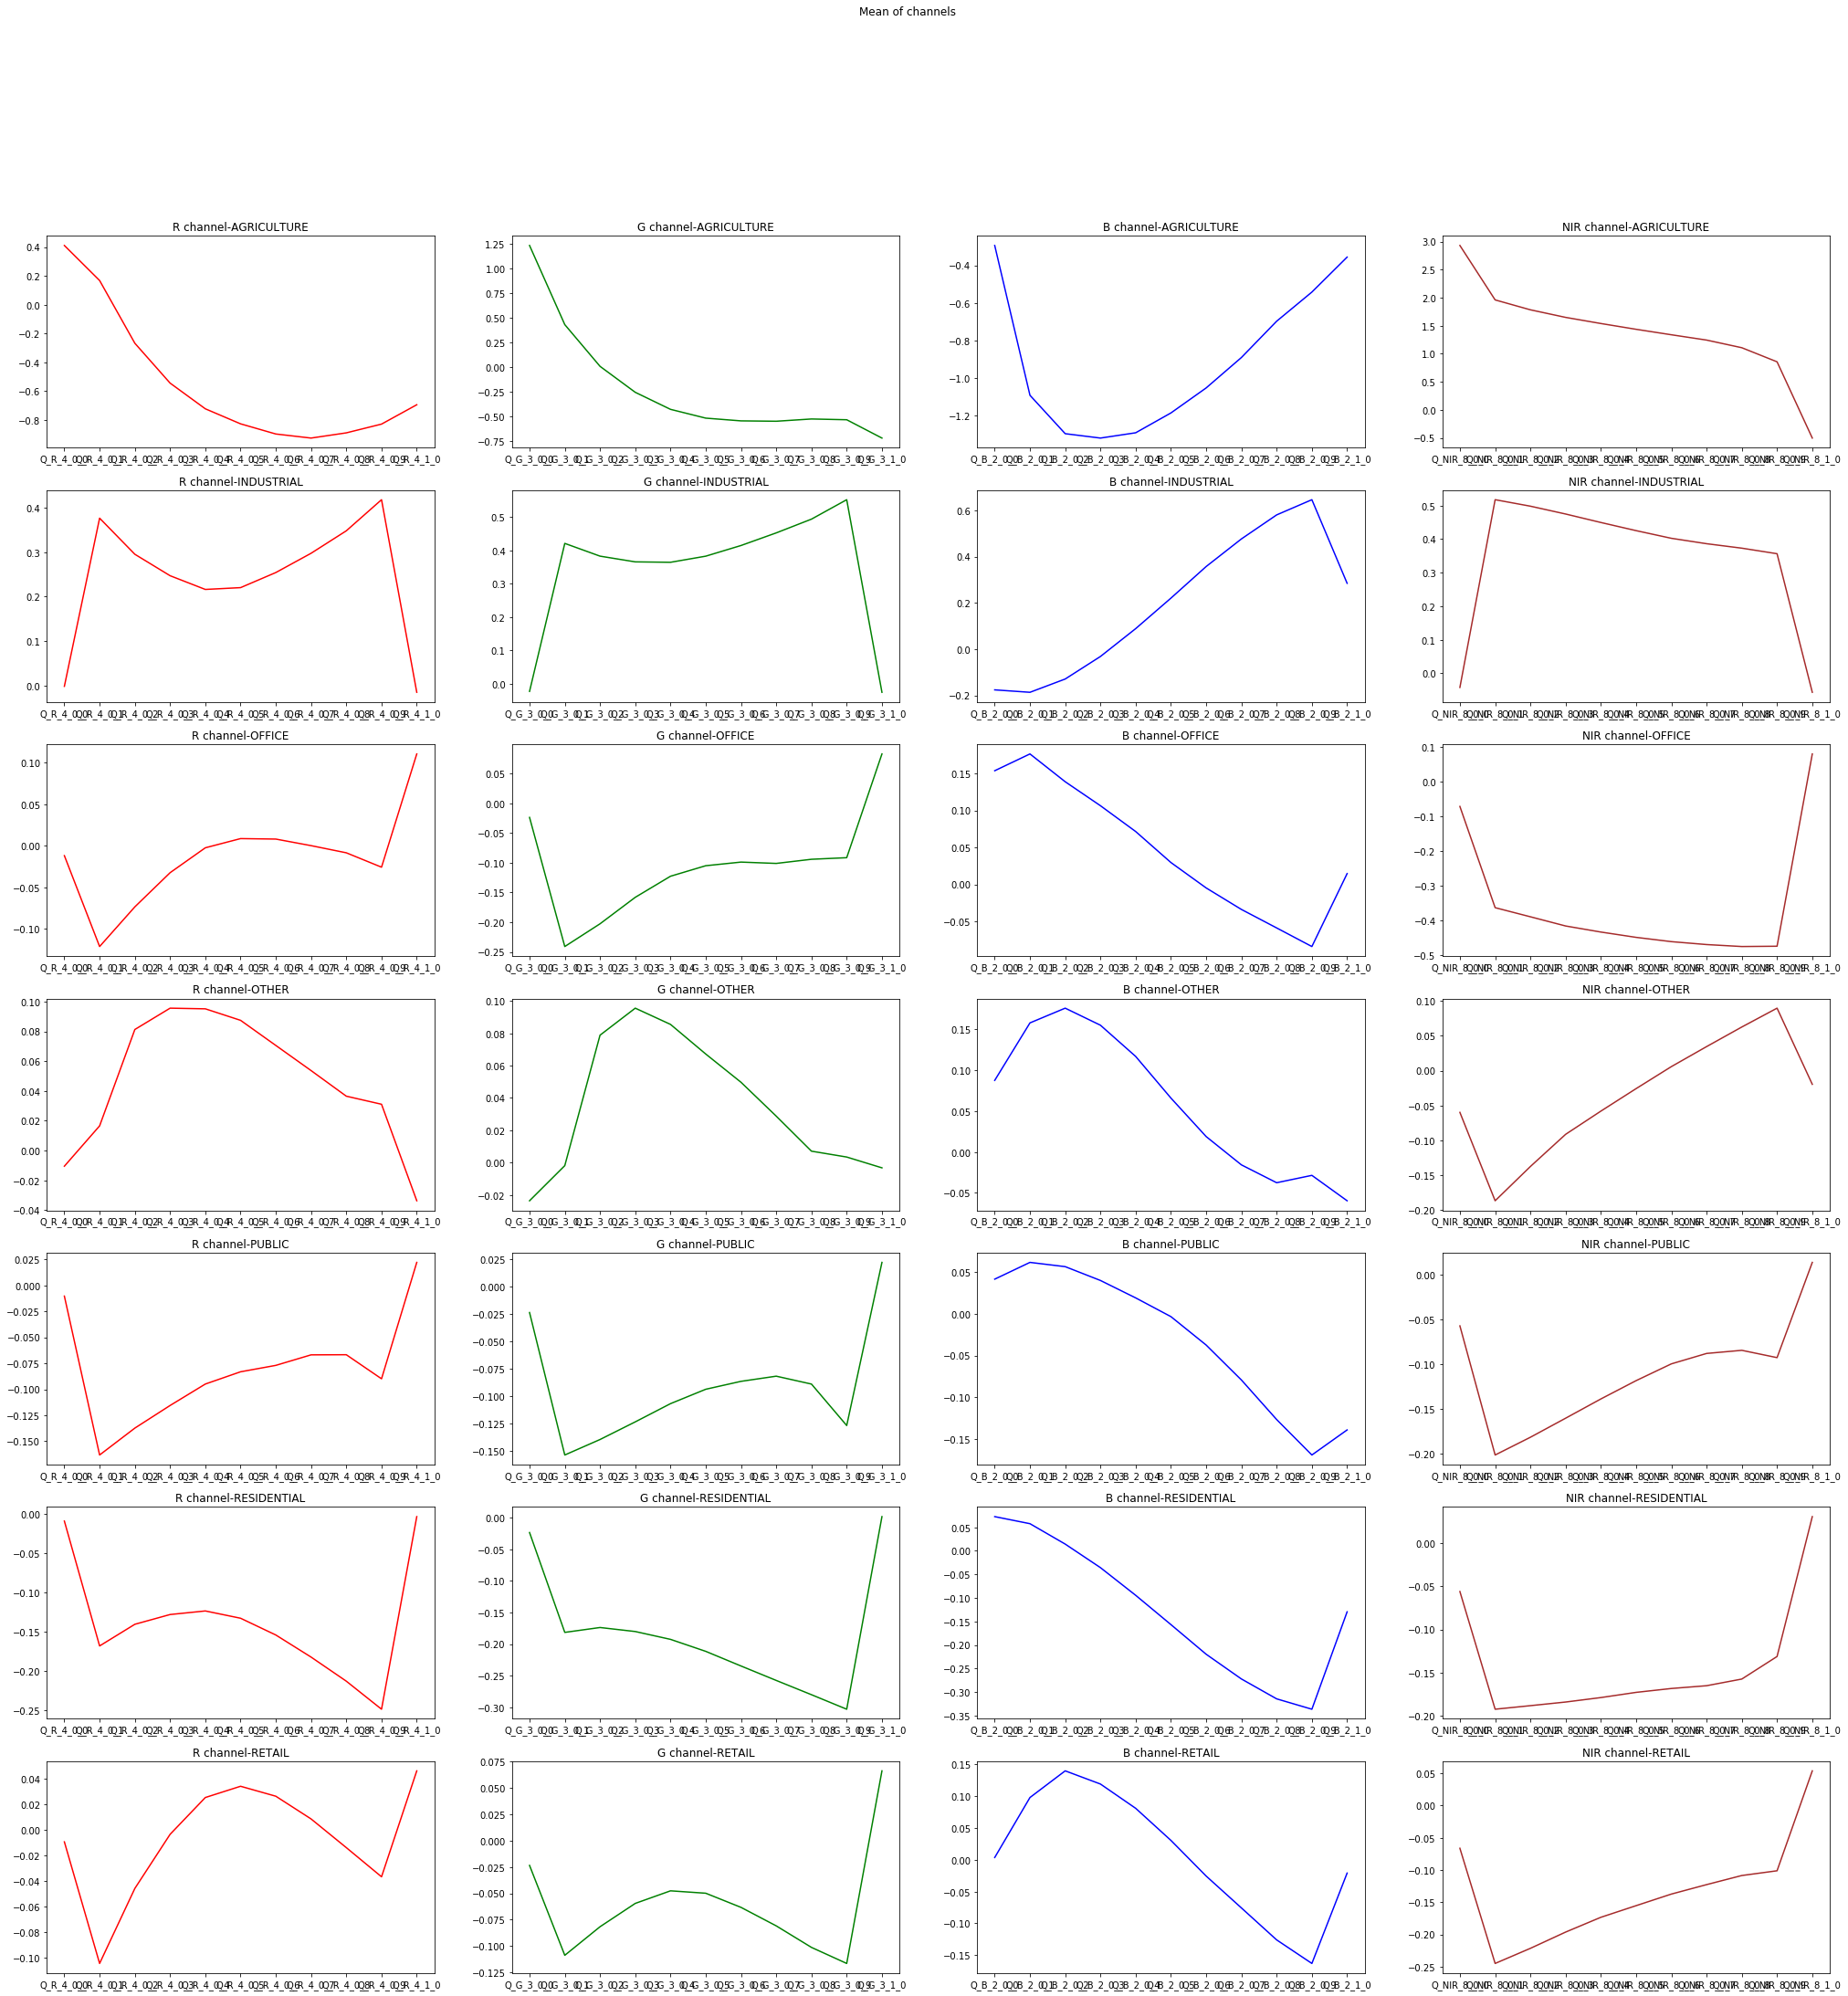

In [18]:
channels_normalized = balanced_data_std.copy()
rgbnir_cols = channels_normalized.columns.str.contains("Q_")

group = channels_normalized.iloc[:,rgbnir_cols]
group["CLASE"] = channels_normalized["CLASE"]
class_mean = group.groupby("CLASE").mean()
plot_all_channels(class_mean)

# Polynomial aproximation

In [20]:
def polynom_compute(df):
    polinomials = [] #np.array([])
    x_axis = np.arange(df.shape[1])#/20
    y_axis_array = df.values
    for y_axis in y_axis_array:
        r = np.polyfit(x_axis,y_axis, 2)
        polinomials.append(r)
    #x_axis = np.tile(np.arange(df.shape[1]), (df.shape[0],1))
    pol_df = pd.DataFrame(polinomials, index = df.index, columns = ["x2","x1", "x0"] )
    return pol_df
    
    

In [71]:
def extract_channels(df, drop_tails = False, return_class_for_each = False, return_class_df = True, normalize = False):
    channels = ["Q_R","Q_G","Q_B","Q_NIR"]
    channel_dfs = []
    for c in channels:
        col_filter = df.columns.str.contains(c)
        if drop_tails:
            col_filter = col_filter * np.invert(df.columns.str.endswith("_0"))
        if return_class_for_each:
            index = list(balanced_data_std.columns).index("CLASE")
            col_filter[index] = True
        channel_dfs.append(df[df.columns[col_filter]])
    if return_class_df:
        channel_dfs.append(df["CLASE"])
    if normalize:
        for i in range(len(channel_dfs)):
            df = channel_dfs[i]
            channel_dfs[i] = (df - df.mean())/df.std()    
    return channel_dfs

In [22]:
rgbnir = balanced_data_std.copy()
rgbnir_cols = rgbnir.columns.str.contains("Q_")
bad_channels = rgbnir.columns.str.endswith("_0")
good_channels = rgbnir_cols  *  np.invert(bad_channels)
rgbnir = rgbnir.iloc[:,good_channels]
rgbnir["CLASE"] = balanced_data_std["CLASE"]



In [32]:
df_r, df_g, df_b, df_nir   = extract_channels(balanced_data_std, True, False, False, True)

pol_df_r = polynom_compute(df_r).add_suffix("_r")
pol_df_g = polynom_compute(df_g).add_suffix("_g")
pol_df_b = polynom_compute(df_b).add_suffix("_b")
pol_df_nir = polynom_compute(df_nir).add_suffix("_nir")



In [24]:
extras = balanced_data_std[['ID', 'X', 'Y','AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3',
       'GEOM_R4', 'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID','CLASE','AGRICULTURE', 'INDUSTRIAL', 'OFFICE', 'OTHER', 'PUBLIC',
       'RESIDENTIAL', 'RETAIL']]
pol_df = pd.concat([pol_df_r, pol_df_g, pol_df_b, pol_df_nir], axis = 1)
pol_df = (pol_df - pol_df.mean())/pol_df.std()
pol_df = pd.concat([pol_df, extras], axis = 1)

In [25]:
pol_df.head()

,x2_r,x1_r,x0_r,x2_g,x1_g,x0_g,x2_b,x1_b,x0_b,x2_nir,...,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE,AGRICULTURE,INDUSTRIAL,OFFICE,OTHER,PUBLIC,RESIDENTIAL,RETAIL
9,1.821519,-1.768544,0.459879,1.329720,-1.210248,0.664256,0.489588,0.513996,-1.295773,2.146369,...,-0.986297,-0.430020,INDUSTRIAL,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12,-0.318380,0.365317,-0.386961,-1.007513,1.055391,-0.493227,0.134802,-0.217810,0.009863,-0.515572,...,0.637432,0.168735,PUBLIC,0.0,0.0,0.0,0.0,1.0,0.0,0.0
37,0.002109,0.149967,-0.894828,-0.259541,0.645733,-1.291101,0.383270,-0.734341,0.445752,0.305130,...,-0.986297,0.767490,PUBLIC,0.0,0.0,0.0,0.0,1.0,0.0,0.0
48,-0.714322,0.446096,0.345792,-0.391880,-0.021931,0.624450,-0.490947,0.192652,0.318012,0.075361,...,-0.445054,-0.430020,INDUSTRIAL,0.0,1.0,0.0,0.0,0.0,0.0,0.0
55,0.975940,0.337166,1.402870,-0.096589,1.301664,1.572925,-2.409890,3.116711,0.858114,-0.064421,...,-0.986297,0.168735,INDUSTRIAL,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
np.tile(np.arange(9), (100,1))

In [88]:
np.repeat(np.arange(9), 10).reshape(10,9).T

array([[0, 0, 1, 2, 3, 4, 5, 6, 7, 8],
       [0, 1, 1, 2, 3, 4, 5, 6, 7, 8],
       [0, 1, 2, 2, 3, 4, 5, 6, 7, 8],
       [0, 1, 2, 3, 3, 4, 5, 6, 7, 8],
       [0, 1, 2, 3, 4, 4, 5, 6, 7, 8],
       [0, 1, 2, 3, 4, 5, 5, 6, 7, 8],
       [0, 1, 2, 3, 4, 5, 6, 6, 7, 8],
       [0, 1, 2, 3, 4, 5, 6, 7, 7, 8],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]])

## Artificial Neural Network

Incluyendo las librerías necesarias

In [45]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

División de los datos en atributos y etiquetas. También se divide el data set en dos grupos: Train and Test.

In [31]:
from sklearn.utils import shuffle

In [32]:
balanced_data_std = shuffle(balanced_data_std)
print(balanced_data_std.shape)
balanced_data_std = balanced_data_std.dropna()
print(balanced_data_std.shape)

(3169, 63)
(3164, 63)


In [9]:
# DATA

def create_features(balanced_data_std):
    TRAIN_RATE = 0.9
    balanced_data_std = balanced_data_std.dropna()
    n_instances = balanced_data_std.shape[0]

    features = balanced_data_std.drop(['CLASE','ID'], axis = 1)


    # SOFTMAX FOR THE OUTPUT
    enc = OneHotEncoder(handle_unknown='ignore', sparse = False)
    df_cls = balanced_data_std.CLASE.values.reshape(-1, 1)
    labels = pd.DataFrame(enc.fit_transform(df_cls), columns = enc.categories_[0])

    features = features.drop(labels.columns.values, axis = 1)
    return features, labels

'''
n_train = int(n_instances*TRAIN_RATE)
n_test = int((n_instances-n_train))

x_train = features.values[:n_train]
t_train = labels.values[:n_train]

x_test = features.values[n_train:n_train+n_test]
t_test = labels.values[n_train:n_train+n_test]

x_train = np.asarray(x_train)
t_train = np.asarray(t_train)
x_test = np.asarray(x_test)
t_test = np.asarray(t_test)

print ("x_train:",x_train.shape)
print ("t_train:",t_train.shape)

print ("x_test:",x_test.shape)
print ("t_test:",t_test.shape)
'''

'\nn_train = int(n_instances*TRAIN_RATE)\nn_test = int((n_instances-n_train))\n\nx_train = features.values[:n_train]\nt_train = labels.values[:n_train]\n\nx_test = features.values[n_train:n_train+n_test]\nt_test = labels.values[n_train:n_train+n_test]\n\nx_train = np.asarray(x_train)\nt_train = np.asarray(t_train)\nx_test = np.asarray(x_test)\nt_test = np.asarray(t_test)\n\nprint ("x_train:",x_train.shape)\nprint ("t_train:",t_train.shape)\n\nprint ("x_test:",x_test.shape)\nprint ("t_test:",t_test.shape)\n'

### Initialization

In [10]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, InputLayer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
import sys
import pandas as pd
import numpy as np

Using TensorFlow backend.


### Data import

In [68]:
from sklearn.model_selection import train_test_split

In [30]:
balanced_data = pd.read_csv("balanced_data.csv", index_col = 0)
balanced_data_std = pd.read_csv("balanced_data_standarized.csv", index_col = 0)
#data_std = pd.read_csv("data_standarized.csv", index_col = 0)


In [26]:
features, labels =  create_features(pol_df)
x_train, x_test, t_train, t_test = train_test_split(features, labels, test_size=0.1, random_state=1)

x_train, x_dev, t_train, t_dev = train_test_split(x_train, t_train, test_size=0.1, random_state=1)

# NEURAL NET

In [46]:
def evaluate_and_plot(model, history):
    score = model.evaluate(x_test, t_test)
    print("loss=" + str(score[0]) + " accuracy=" + str(score[1]))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(["acc", "val_acc"])

# GRID SEARCH
https://stackabuse.com/grid-search-optimization-algorithm-in-python/

In [14]:
INPUTS = x_train.shape[1]
OUTPUTS = t_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(x_train.shape[0]/1))
NUM_TEST_EXAMPLES = int (round (x_test.shape[0]/1))
n_neurons_per_hlayer = [100, 100, 100, 100] 

def create_model(learn_rate, dropout_rate):
    model = Sequential()
    model.add(Dense(INPUTS, activation='relu', input_dim=INPUTS))

    for neurons in n_neurons_per_hlayer:
        model.add(Dense(neurons, activation="relu"))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization())
        
    model.add(Dense(OUTPUTS, activation="softmax"))
    
    
    save_model = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss')

    
    model.compile(loss="categorical_crossentropy",
              optimizer=Adam(lr=learn_rate),
              metrics=["accuracy"] )#,  callbacks=[save_model])
    
    return model



In [31]:
balanced_data.head()

,ID,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,...,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE
9,A4A6D078FB1079E5,2267210836,165899063,0.001099,454.999338,573.005005,668.002612,752.999573,853.000122,1005.999158,...,5997.459077,333.617230,0.860099,0.046252,0.055740,1.205122,1990,1.0,6,INDUSTRIAL
12,FB6B4F4CCDDFFFEA,2230759603,165513206,0.000000,344.003510,537.000488,678.994141,800.003784,926.997253,1070.998901,...,6979.220122,4940.190125,0.439537,0.007455,0.011935,1.600917,1972,7.0,5,PUBLIC
37,BB583854631D2230,2211010954,165763886,0.000000,293.001501,457.001654,587.001526,709.998523,829.998901,962.994055,...,5633.080783,266.684700,0.593868,0.029394,0.075758,2.577273,2003,1.0,4,PUBLIC
48,DD2738D28B2657A7,2200805520,165402348,0.000000,443.000015,619.998291,762.994049,907.004028,1054.002991,1202.999023,...,6070.418723,78.703600,0.509471,0.082988,0.078003,0.939938,1986,3.0,6,INDUSTRIAL
55,228D02BFDA3E731F,2258691626,165690306,0.000000,572.003784,765.000366,924.996460,1097.998169,1329.000732,1609.997925,...,14891.610338,990.160964,0.530351,0.020504,0.026123,1.274086,1969,1.0,5,INDUSTRIAL


In [ ]:
df_r, df_g, df_b, df_nir 

In [44]:
a = df_r.values[0]
b = df_g.values[0]
c = df_b.values[0]
d = df_nir.values[0]

In [38]:
b = df_g.values[0]

In [42]:
print(a)
print(b)

[ 0.49574609  0.06223196 -0.23311351 -0.48882469 -0.62398121 -0.52134904
 -0.34904957 -0.21343733 -0.0730897 ]
[ 0.58860713  0.51522032  0.27143801  0.06154044 -0.05905282 -0.01794026
  0.13355221  0.23852662  0.40040295]


In [51]:
test = np.vstack((df_r.values,df_g.values,df_b.values,df_nir.values)).T

In [69]:
def merge_for_Cnn1(df_r, df_g, df_b, df_nir ):
    merge = []
    for a,b,c,d in zip(df_r.values,df_g.values,df_b.values,df_nir.values):
        row = np.vstack((a,b,c,d)).T
        merge.append(row)
    merge = np.array(merge)
    return merge

In [72]:
df_r, df_g, df_b, df_nir = extract_channels(balanced_data_std, True, False, False, True)
data_rgbnir = merge_for_Cnn1(df_r, df_g, df_b, df_nir)

In [45]:
np.vstack((a,b,c,d)).T

array([[ 0.49574609,  0.58860713, -1.14980898,  1.54121454],
       [ 0.06223196,  0.51522032, -1.26927637,  1.36693985],
       [-0.23311351,  0.27143801, -1.15877331,  1.37958796],
       [-0.48882469,  0.06154044, -0.91947968,  1.42131398],
       [-0.62398121, -0.05905282, -0.58694255,  1.45060734],
       [-0.52134904, -0.01794026, -0.19266858,  1.50057599],
       [-0.34904957,  0.13355221,  0.21926799,  1.59929656],
       [-0.21343733,  0.23852662,  0.44620722,  1.91397179],
       [-0.0730897 ,  0.40040295,  0.42393094,  2.53639686]])

In [73]:

labels = balanced_data_std[['AGRICULTURE', 'INDUSTRIAL', 'OFFICE', 'OTHER', 'PUBLIC',
       'RESIDENTIAL', 'RETAIL']]

In [74]:
x_train, x_test, t_train, t_test = train_test_split(merge, labels, test_size=0.1, random_state=1)

x_train, x_dev, t_train, t_dev = train_test_split(x_train, t_train, test_size=0.1, random_state=1)

In [ ]:
 cnn = Sequential()
    cnn.add(Conv1D(32, kernel_size= kernel, activation='tanh', input_shape=(seq_length,4)))
    cnn.add(Conv1D(64, kernel_size= kernel, activation='tanh'))
    #model.add(MaxPooling1D(kernel))
    cnn.add(Conv1D(64, kernel_size= kernel, activation='tanh'))
    cnn.add(Conv1D(128, kernel_size= kernel, activation='tanh'))
    cnn.add(GlobalAveragePooling1D())
    cnn.add(Dropout(0.5))
    cnn.add(Dense(7, activation='sigmoid'))

In [ ]:
test.add(Dense(100, activation = "relu", input_dim = test_data.shape[1]))
test.add(Dense(100, activation = "relu"))
test.add(Dropout(0.2))
test.add(BatchNormalization())
test.add(Dense(100, activation = "relu"))
test.add(Dropout(0.2))
test.add(BatchNormalization())
test.add(Dense(100, activation = "relu"))
test.add(Dropout(0.2))
test.add(BatchNormalization())
test.add(Dense(7, activation = "softmax"))
test.compile(loss='categorical_crossentropy',
              optimizer= "adam" ,
              metrics=['accuracy'])


In [63]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Concatenate, Input, concatenate, BatchNormalization
from keras.layers import Embedding, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.initializers import glorot_normal


def merged_net():
    
    dropout_rate = 0.2
    #https://statcompute.wordpress.com/2017/01/08/an-example-of-merge-layer-in-keras/ 
    
    #DENSE net
    dense_input = Input(shape=(data_dense.shape[1],), name='main_input')
    dense = Dense(250, activation='relu')(dense_input)
    dense = Dropout(dropout_rate)(dense)
    dense = BatchNormalization()(dense)
    dense = Dense(200, activation='relu')(dense)
    dense = Dropout(dropout_rate)(dense)
    dense = BatchNormalization()(dense)
    dense= Dense(100, activation='relu')(dense)
    dense = Dropout(dropout_rate)(dense)
    dense_out = BatchNormalization()(dense)
    dense= Dense(100, activation='relu')(dense)
    dense = Dropout(dropout_rate)(dense)
    dense_out = BatchNormalization()(dense)
    
    #CNN1D
    seq_length = 9
    kernel = 2
    
    cnn_input = Input(shape=(seq_length,4), name='cnn_input')
    cnn = Conv1D(32, kernel_size= kernel, activation='relu')(cnn_input)
    cnn = Conv1D(64, kernel_size= kernel, activation='relu')(cnn)
    cnn = Conv1D(64, kernel_size= kernel, activation='relu')(cnn)
    cnn = Conv1D(128, kernel_size= kernel, activation='relu')(cnn)
    #cnn = GlobalAveragePooling1D()(cnn)
    cnn = Flatten()(cnn)
    cnn_out = Dropout(dropout_rate)(cnn)
    
    #save_model = ModelCheckpoint('best_merged_model.hdf5', save_best_only=True, monitor='val_loss')

    #MERGED net
    concat = concatenate([cnn_out, dense_out])
    concat = Dense(50, activation='relu')(concat)
    model_output = Dense(7, activation='sigmoid')(concat)
    
    model = Model(inputs=[cnn_input, dense_input], outputs=[model_output])

    #model = Dense(50, activation='relu')(model)
    model.compile(loss='categorical_crossentropy',
                  optimizer= "adam" ,
                  metrics=['accuracy'])
    return model
    

In [80]:
x_train, x_test, t_train, t_test = train_test_split(balanced_data_std, labels, test_size=0.1, random_state=1)
data_dense_train = x_train[['X', 'Y','AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3',
       'GEOM_R4', 'CONTRUCTIONYEAR']]
data_dense_test = x_test[['X', 'Y','AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3',
       'GEOM_R4', 'CONTRUCTIONYEAR']]

df_r, df_g, df_b, df_nir = extract_channels(x_train, True, False, False, True)
data_rgbnir_train = merge_for_Cnn1(df_r, df_g, df_b, df_nir)

df_r, df_g, df_b, df_nir = extract_channels(x_test, True, False, False, True)
data_rgbnir_test = merge_for_Cnn1(df_r, df_g, df_b, df_nir)

In [ ]:
#model = merged_net()

In [89]:
model_prev = merged_net()

In [ ]:
estimate_processed

In [91]:
data_dense_estimate = estimate_processed[['X', 'Y','AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3',
       'GEOM_R4', 'CONTRUCTIONYEAR']]
df_r, df_g, df_b, df_nir = extract_channels(estimate_processed, True, False, False, True)
data_rgbnir_estimate = merge_for_Cnn1(df_r, df_g, df_b, df_nir)


In [90]:
model_prev.load_weights("functionaL_model")

In [92]:
predictions = model_prev.predict([data_rgbnir_estimate,data_dense_estimate])

In [94]:
predictions[0]

array([6.9946051e-05, 1.3667947e-01, 5.9505403e-03, 8.6269212e-01,
       1.5112433e-01, 2.7944684e-02, 1.2950152e-02], dtype=float32)

In [84]:
#model.save("functionaL_model")

In [85]:

history2 = model.fit([data_rgbnir_train, data_dense_train], t_train.values,batch_size = 32, epochs = 100)


Epoch 1/100
16251/16251 [==============================] - 3s 192us/step - loss: 0.9572 - acc: 0.6296
Epoch 2/100
16251/16251 [==============================] - 3s 195us/step - loss: 0.9520 - acc: 0.6303
Epoch 3/100
16251/16251 [==============================] - 3s 191us/step - loss: 0.9556 - acc: 0.6295
Epoch 4/100
16251/16251 [==============================] - 3s 187us/step - loss: 0.9492 - acc: 0.6330
Epoch 5/100
16251/16251 [==============================] - 3s 189us/step - loss: 0.9524 - acc: 0.6293
Epoch 6/100
16251/16251 [==============================] - 3s 190us/step - loss: 0.9523 - acc: 0.6304
Epoch 7/100
16251/16251 [==============================] - 3s 190us/step - loss: 0.9537 - acc: 0.6294
Epoch 8/100
16251/16251 [==============================] - 3s 197us/step - loss: 0.9484 - acc: 0.6294
Epoch 9/100
16251/16251 [==============================] - 4s 216us/step - loss: 0.9504 - acc: 0.6289
Epoch 10/100
16251/16251 [==============================] - 3s 200us/step - loss: 

In [81]:
def evaluate_and_plot(model, history):
    score = model.evaluate([data_rgbnir_test, data_dense_test],t_test)
    print("loss=" + str(score[0]) + " accuracy=" + str(score[1]))
    plt.plot(history.history['acc'])
    #plt.plot(history.history['val_acc'])
    #plt.legend(["acc", "val_acc"])

1806/1806 [==============================] - 1s 445us/step
loss=1.2387430972831195 accuracy=0.5825027686152875


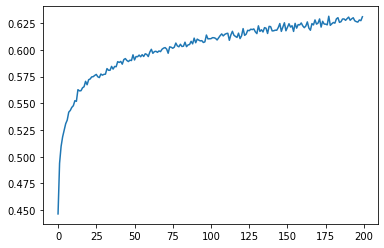

In [109]:
evaluate_and_plot(model_prev, history)

In [209]:
data_dense.shape

(18057, 10)

In [213]:
data_dense.head()

,X,Y,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID
9,1.870963,1.542269,-0.203021,1.609407,-0.120981,0.038949,0.087808,0.807377,-0.986297,-0.430020
12,0.652878,-0.327688,0.877346,-0.481418,-0.810951,-0.700799,0.537255,-0.070829,0.637432,0.168735
37,-0.007059,0.887168,-0.218719,0.285838,-0.420780,0.376993,1.645964,1.441636,-0.986297,0.767490
48,-0.348093,-0.864932,-0.262806,-0.133742,0.532313,0.414914,-0.213325,0.612220,-0.445054,-0.430020
55,1.586278,0.530582,-0.049044,-0.029937,-0.578895,-0.461192,0.166120,-0.217197,-0.986297,0.168735


In [214]:
history = model.fit(data_dense, labels.values,batch_size = None, epochs = 100)


Epoch 1/100
18057/18057 [==============================] - 2s 89us/step - loss: nan - acc: 0.0187
Epoch 2/100
18057/18057 [==============================] - 2s 85us/step - loss: nan - acc: 0.0187
Epoch 3/100
18057/18057 [==============================] - 2s 88us/step - loss: nan - acc: 0.0187
Epoch 4/100
18057/18057 [==============================] - 2s 89us/step - loss: nan - acc: 0.0187
Epoch 5/100
 5056/18057 [=======>......................] - ETA: 1s - loss: nan - acc: 0.0182

KeyboardInterrupt: 

In [216]:
labels.head()

,AGRICULTURE,INDUSTRIAL,OFFICE,OTHER,PUBLIC,RESIDENTIAL,RETAIL
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,1.0,0.0,0.0
37,0.0,0.0,0.0,0.0,1.0,0.0,0.0
48,0.0,1.0,0.0,0.0,0.0,0.0,0.0
55,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [8]:
balanced_data_std.columns[-7:]

Index(['AGRICULTURE', 'INDUSTRIAL', 'OFFICE', 'OTHER', 'PUBLIC', 'RESIDENTIAL',
       'RETAIL'],
      dtype='object')

In [29]:
balanced_data_std.columns

Index(['ID', 'X', 'Y', 'Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3',
       'Q_R_4_0_4', 'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8',
       'Q_R_4_0_9', 'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2',
       'Q_G_3_0_3', 'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7',
       'Q_G_3_0_8', 'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1',
       'Q_B_2_0_2', 'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6',
       'Q_B_2_0_7', 'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0',
       'Q_NIR_8_0_1', 'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4',
       'Q_NIR_8_0_5', 'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8',
       'Q_NIR_8_0_9', 'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3',
       'GEOM_R4', 'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID',
       'CLASE', 'AGRICULTURE', 'INDUSTRIAL', 'OFFICE', 'OTHER', 'PUBLIC',
       'RESIDENTIAL', 'RETAIL'],
      dtype='object')

In [58]:
data_dense = balanced_data_std[['X', 'Y','AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3',
       'GEOM_R4', 'CONTRUCTIONYEAR']]

In [40]:
labels = balanced_data_std[['AGRICULTURE', 'INDUSTRIAL', 'OFFICE', 'OTHER', 'PUBLIC', 'RESIDENTIAL',
       'RETAIL']]
test_data = balanced_data_std[['X', 'Y', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3',
       'GEOM_R4', 'CONTRUCTIONYEAR']]

In [37]:
do not include 'MAXBUILDINGFLOOR'

SyntaxError: invalid syntax (<ipython-input-37-2ba3ecb8a8ce>, line 1)

In [53]:
from keras.regularizers import l2, l1_l2

In [55]:
test = Sequential()
test.add(Dense(100, activation = "relu", input_dim = test_data.shape[1]))
test.add(Dense(100, activation = "relu"))
test.add(Dropout(0.2))
test.add(BatchNormalization())
test.add(Dense(100, activation = "relu"))
test.add(Dropout(0.2))
test.add(BatchNormalization())
test.add(Dense(100, activation = "relu"))
test.add(Dropout(0.2))
test.add(BatchNormalization())
test.add(Dense(7, activation = "softmax"))
test.compile(loss='categorical_crossentropy',
              optimizer= "adam" ,
              metrics=['accuracy'])

history = test.fit(test_data, labels.values, validation_split= 0.2, batch_size = None, epochs = 100)


Train on 14445 samples, validate on 3612 samples
Epoch 1/100
14445/14445 [==============================] - 3s 183us/step - loss: 1.7684 - acc: 0.3448 - val_loss: 1.8559 - val_acc: 0.1249
Epoch 2/100
14445/14445 [==============================] - 1s 66us/step - loss: 1.5446 - acc: 0.4014 - val_loss: 1.8146 - val_acc: 0.1639
Epoch 3/100
14445/14445 [==============================] - 1s 69us/step - loss: 1.4935 - acc: 0.4213 - val_loss: 1.7175 - val_acc: 0.2788
Epoch 4/100
14445/14445 [==============================] - 1s 66us/step - loss: 1.4718 - acc: 0.4247 - val_loss: 1.8047 - val_acc: 0.1622
Epoch 5/100
14445/14445 [==============================] - 1s 69us/step - loss: 1.4463 - acc: 0.4351 - val_loss: 1.8415 - val_acc: 0.2002
Epoch 6/100
14445/14445 [==============================] - 1s 67us/step - loss: 1.4377 - acc: 0.4342 - val_loss: 1.8281 - val_acc: 0.1838
Epoch 7/100
14445/14445 [==============================] - 1s 68us/step - loss: 1.4265 - acc: 0.4441 - val_loss: 1.8378 - 

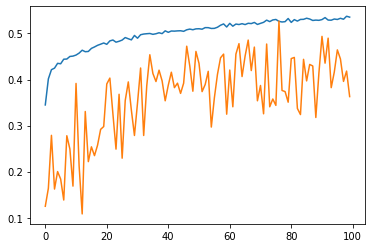

In [56]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])

In [47]:
evaluate_and_plot(test,history)

NameError: name 'x_test' is not defined

In [111]:
data_dense = balanced_data_std[['X', 'Y','AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3',
       'GEOM_R4', 'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID']]

In [112]:
data_rgbnir.shape

(18057, 9, 4)

In [110]:
data_dense.shape

(18057, 10)

In [113]:
labels.shape

(18057, 7)

In [105]:
data_rgbnir = merge.copy()
np.save("data_rgbnir_cnn", data_rgbnir)

In [66]:
data_rgbnir = np.load("data_rgbnir_cnn.npy")

In [15]:
#grid_model.save("first_grid_model")

In [27]:
grid_model = create_model(learn_rate = 0.0001, dropout_rate = 0.2 )
history = grid_model.fit(x_train, t_train, batch_size=100, epochs=150, verbose=1, validation_data = (x_dev, t_dev))

Train on 14609 samples, validate on 1624 samples
Epoch 1/150
14609/14609 [==============================] - 3s 204us/step - loss: 2.3582 - acc: 0.1780 - val_loss: 1.7796 - val_acc: 0.3356
Epoch 2/150
14609/14609 [==============================] - 1s 84us/step - loss: 2.1357 - acc: 0.2408 - val_loss: 1.6860 - val_acc: 0.3781
Epoch 3/150
14609/14609 [==============================] - 1s 84us/step - loss: 2.0077 - acc: 0.2794 - val_loss: 1.6303 - val_acc: 0.3996
Epoch 4/150
14609/14609 [==============================] - 1s 83us/step - loss: 1.9167 - acc: 0.3182 - val_loss: 1.5927 - val_acc: 0.4076
Epoch 5/150
14609/14609 [==============================] - 1s 82us/step - loss: 1.8642 - acc: 0.3292 - val_loss: 1.5678 - val_acc: 0.4107
Epoch 6/150
14609/14609 [==============================] - 1s 83us/step - loss: 1.8172 - acc: 0.3503 - val_loss: 1.5462 - val_acc: 0.4255
Epoch 7/150
14609/14609 [==============================] - 1s 81us/step - loss: 1.7807 - acc: 0.3579 - val_loss: 1.5284 - 

Epoch 118/150
14609/14609 [==============================] - 1s 81us/step - loss: 1.2433 - acc: 0.5449 - val_loss: 1.2044 - val_acc: 0.5653
Epoch 119/150
14609/14609 [==============================] - 1s 84us/step - loss: 1.2379 - acc: 0.5498 - val_loss: 1.2026 - val_acc: 0.5659
Epoch 120/150
14609/14609 [==============================] - 1s 86us/step - loss: 1.2405 - acc: 0.5466 - val_loss: 1.2004 - val_acc: 0.5659
Epoch 121/150
14609/14609 [==============================] - 1s 82us/step - loss: 1.2437 - acc: 0.5462 - val_loss: 1.1997 - val_acc: 0.5647
Epoch 122/150
14609/14609 [==============================] - 1s 91us/step - loss: 1.2346 - acc: 0.5484 - val_loss: 1.1984 - val_acc: 0.5640
Epoch 123/150
14609/14609 [==============================] - 1s 88us/step - loss: 1.2389 - acc: 0.5459 - val_loss: 1.1975 - val_acc: 0.5628
Epoch 124/150
14609/14609 [==============================] - 1s 88us/step - loss: 1.2365 - acc: 0.5488 - val_loss: 1.1960 - val_acc: 0.5634
Epoch 125/150
14609/

1804/1804 [==============================] - 0s 45us/step
loss=1.2217316680366872 accuracy=0.554323725121513


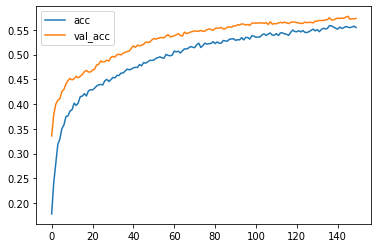

In [28]:
evaluate_and_plot(grid_model, history)

# create csv

El fichero de esta entrega intermedia optativa deberá cumplir con el formato siguiente:
Tanto el asunto del email como el nombre los ficheros deben seguir la siguiente nomenclatura:
       “Minsait_<<Centro>>_<<Nombre de Equipo>>_numeral”
       Ejemplo: “Minsait_Universidad Estatal_dataminders _1” (asunto)
       Ejemplo: “Minsait_Universidad Estatal_dataminders _1.txt” (fichero)
Filas: 5618 (sin computar la cabecera)
Columnas: 2
ID: identificación de cada registro
CLASE: valor predicho
Separador: símbolo pipe, “|”
Codificación en UTF-8

In [121]:
name = "Minsait_Universidad Politecnica Madrid_bestermans_1"
data

In [103]:
def generate_output(df, name = "Universidad Politecnica Madrid_bestermans.txt"):
    df.columns =   ["ID","CLASE"]
    df.to_csv(name, sep = "|", index = False)

In [17]:
estimate.head()

,ID,CLASE
0,44198C2A811A4DF4,RESIDENTIAL
1,216F638609E0E39E,RESIDENTIAL
2,FFFCEFB11E257364,RESIDENTIAL
3,596C5C8CE10BCF,RESIDENTIAL
4,F931B9FA2A8641D1,RESIDENTIAL


In [18]:
estimate["CLASE"] = "RESIDENTIAL"

C:\Users\HPfamiliaRuiz-Tagle\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
generate_output(estimate)

In [20]:
estimate.shape

(5618, 2)

In [11]:
estimate = estimate[["ID", "CLASE"]]

In [124]:
estimate_std = process_data(estimate)
estimate_features, labels = create_features(estimate_std)

In [131]:
estimate_input = estimate_std.drop(["ID", "CLASE", "UNKNOWN"], axis = 1)

In [ ]:
data.to_csv()

In [154]:
predictions = grid_model.predict(estimate_std)

In [97]:
dictionary = {i: terreno for i , terreno in zip(range(7),t_train.columns.values)}

In [98]:
dictionary

{0: 'AGRICULTURE',
 1: 'INDUSTRIAL',
 2: 'OFFICE',
 3: 'OTHER',
 4: 'PUBLIC',
 5: 'RESIDENTIAL',
 6: 'RETAIL'}

In [99]:
results = []
for p in predictions:
    pos = np.argmax(p)
    print(pos)
    results.append(dictionary.get(pos))

3
5
5
2
3
3
2
5
1
4
1
2
6
2
6
5
4
1
1
5
4
2
5
2
2
3
3
1
1
5
2
2
5
1
5
2
4
1
1
2
3
3
2
4
1
1
1
4
5
1
4
1
2
1
1
1
1
1
1
2
1
3
1
1
1
6
2
3
5
1
5
1
1
5
2
4
1
1
1
1
4
3
0
4
5
1
1
5
4
1
3
1
5
1
4
5
4
5
1
2
4
2
5
3
3
1
3
5
4
4
1
4
4
5
4
6
1
1
1
2
1
1
3
2
5
4
6
1
1
1
1
3
4
5
5
1
1
4
1
5
3
2
6
1
0
5
3
5
1
5
4
1
1
3
4
6
6
1
4
5
5
5
1
1
6
1
1
4
3
5
3
1
0
6
4
1
5
1
0
5
5
4
5
5
0
1
1
6
4
4
1
3
4
1
3
5
1
5
1
1
4
4
6
3
3
4
6
5
2
1
1
4
1
4
4
1
6
1
1
5
1
5
1
1
5
5
4
1
1
1
2
5
4
4
4
1
1
4
1
1
4
1
0
2
4
6
4
5
2
1
1
3
1
1
5
1
4
3
6
4
4
1
5
1
1
0
4
1
4
5
1
1
1
3
1
4
0
1
6
1
1
5
1
4
1
4
4
1
3
1
5
1
4
1
1
5
4
4
1
1
2
5
4
4
4
5
1
1
4
4
2
1
4
5
4
4
5
4
4
5
5
4
1
1
3
3
1
4
4
6
6
5
4
1
1
1
3
1
5
1
1
5
1
3
1
1
4
4
1
1
2
4
1
1
1
5
5
1
2
1
1
5
1
4
5
1
3
2
4
5
1
1
1
5
6
1
2
4
4
4
3
3
2
5
0
1
0
1
1
2
4
1
5
2
3
4
5
2
1
4
1
3
0
2
5
1
2
6
5
4
3
6
1
6
5
2
3
3
1
5
1
0
2
4
1
4
4
4
1
1
1
6
1
4
6
6
1
1
6
3
5
1
3
4
5
3
1
4
5
5
0
3
1
5
0
4
3
5
1
1
5
6
5
4
4
5
1
5
1
3
2
4
5
5
3
5
5
6
1
2
1
6
0
1
1
6
4
1
3
5
0
4
6
2
2
1
4
1
1
1


5
5
5
1
1
4
5
5
5
5
5
5
6
5
4
5
6
1
5
1
5
5
5
5
4
5
5
1
5
5
5
5
1
5
5
5
2
5
5
5
1
5
2
5
5
5
5
5
5
4
5
5
6
4
5
5
5
6
5
5
5
4
5
5
5
3
4
5
5
5
5
1
5
5
5
5
5
4
5
5
5
5
5
5
5
5
4
6
5
5
5


In [197]:
dictionary.get(3)

'OTHER'

In [164]:
np.argmax(predictions[0])

3

In [100]:
final_result = pd.concat([estimate["ID"],pd.DataFrame(results)], axis = 1)
final_result.columns = ["ID","CLASE"]

In [101]:
final_result["CLASE"].unique()

array(['OTHER', 'RESIDENTIAL', 'OFFICE', 'INDUSTRIAL', 'PUBLIC', 'RETAIL',
       'AGRICULTURE'], dtype=object)

In [102]:
final_result["CLASE"].unique().shape

(7,)

In [104]:
generate_output(final_result)

In [106]:
final_result.head()

,ID,CLASE
0,44198C2A811A4DF4,OTHER
1,216F638609E0E39E,RESIDENTIAL
2,FFFCEFB11E257364,RESIDENTIAL
3,596C5C8CE10BCF,OFFICE
4,F931B9FA2A8641D1,OTHER


In [ ]:
from sklearn.neural_network import MLPClassifier


In [224]:
data_mlp = balanced_data[["ID","X","Y","CLASE"]]
x_train, x_test, t_train, t_test = train_test_split(data_mlp.drop(["CLASE"],1), data_mlp["CLASE"], test_size=0.2, random_state=1)


In [211]:
est = estimate[["ID","X","Y","CLASE"]]

In [227]:
X = x_train.drop(["ID"],1)
labels = t_train
clf = MLPClassifier(hidden_layer_sizes=(100, 20), random_state=1)
clf.fit(X, labels)

C:\Users\HPfamiliaRuiz-Tagle\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 20), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [ ]:
x_test

In [229]:
predictions = clf.predict(x_test.drop(["ID"],1))

In [231]:
from sklearn.metrics import classification_report

In [232]:
report = classification_report(t_test, predictions)


In [233]:

print(report)

              precision    recall  f1-score   support

 AGRICULTURE       0.64      0.38      0.48        71
  INDUSTRIAL       0.56      0.65      0.60       901
      OFFICE       0.30      0.28      0.29       381
       OTHER       0.36      0.09      0.14       226
      PUBLIC       0.47      0.11      0.18       624
 RESIDENTIAL       0.40      0.73      0.51       996
      RETAIL       0.32      0.08      0.13       413

    accuracy                           0.44      3612
   macro avg       0.43      0.33      0.33      3612
weighted avg       0.43      0.44      0.39      3612

